In [2]:
import numpy as np
import pylab as plt

In [3]:
size = 300

vortex_spacing = 0.5
extra_factor = 2.

a = np.array([1,0])*vortex_spacing
b = np.array([np.cos(np.pi/3),np.sin(np.pi/3)])*vortex_spacing
rnv = int(2*extra_factor/vortex_spacing)
vortices = [n*a+m*b for n in range(-rnv,rnv) for m in range(-rnv,rnv)]
vortices = [(x,y) for (x,y) in vortices if -extra_factor<x<extra_factor and -extra_factor<y<extra_factor]


xs = np.linspace(-1,1,size).astype(np.float64)[None,:]
ys = np.linspace(-1,1,size).astype(np.float64)[:,None]

vx = np.zeros((size,size),dtype=np.float64)
vy = np.zeros((size,size),dtype=np.float64)
for (x,y) in vortices:
    rsq = (xs-x)**2+(ys-y)**2
    vx +=  (ys-y)/rsq
    vy += -(xs-x)/rsq

In [11]:
def advance(ux, uy, x, y, fx, fy, nx, ny):
    eps = 1e-8
    if ux == 0 and uy == 0:
        return None, None, None, None
    if ux < 0:
        dx = fx 
    elif ux > 0:
        dx = 1-fx
    else:
        dx = 0
    if uy < 0:
        dy = fy
    elif uy > 0:
        dy = 1-fy
    else: 
        dy = 0
    tx = dx /(abs(ux)+eps)
    ty = dy /(abs(uy)+eps)
    t = min(tx, ty)
    fx+=ux*t
    fy+=uy*t
    fxx, fyy = None, None
    if fx > 1-eps:
        fxx = 0 
        x += 1
    if fy > 1-eps:
        fyy = 0
        y += 1
    if fx < eps:
        x -= 1
        fxx = 1
    if fy < eps:
        y -= 1
        fyy = 1
    if not fxx is None:
        fx = fxx 
    if not fyy is None:
        fy = fyy
    x = min(max(x, 0), nx-1)
    y = min(max(y, 0), ny-1)
    return x, y, fx, fy 

x_1, y_1, fx_1, fy_1 = advance(-10.29, 10.59, 1, 1, 0.67, 0, 10, 10)
print(x_1, y_1, fx_1, fy_1)

0 1 1 0.6895335270266925


In [22]:
def compute_streamline(vx, vy, texture, px, py, kernel):
    L = len(kernel) // 2
    fv, bv = [], []
    ny, nx = texture.shape[0], texture.shape[1]
    fx, fy, fxr, fyr = 0.5, 0.5, 0.5, 0.5
    x, y, xr, yr = px, py, px, py
    if vx[y][x] == 0 and vy[y][x] == 0:
        return None
    # print("init", x, y, fx, fy)
    for i in range(L):
        # print(vx[y][x], vy[y][x])
        x, y, fx, fy  = advance(vx[y][x], vy[y][x], x, y, fx, fy, nx, ny)
        # print("f", x, y, fx, fy)
        if x is None:
            break
        fv.append(texture[y][x])
    for i in range(L):
        # print(-vx[yr][xr], -vy[yr][xr])
        xr, yr, fxr, fyr = advance(-vx[yr][xr], -vy[yr][xr], xr, yr, fxr, fyr, nx, ny)
        # print("b", xr, yr, fxr, fyr )
        if xr is None:
            break
        bv.append(texture[yr][xr])
    v = np.array(bv[::-1]+[texture[py][px]]+fv)
    init_v = L-len(bv)
    kernel = kernel[init_v:init_v+len(v)]
    return np.sum(v*kernel)

size_test = 100

# Generate 100x100 random noise texture
np.random.seed(123)
texture = np.random.rand(size_test, size_test).astype(np.float64)

# Regenerate vector field with new dimensions
xs = np.linspace(-1,1,size_test).astype(np.float64)[None,:]
ys = np.linspace(-1,1,size_test).astype(np.float64)[:,None]

vx = np.zeros((size_test,size_test),dtype=np.float64)
vy = np.zeros((size_test,size_test),dtype=np.float64)
for (x,y) in vortices:
    rsq = (xs-x)**2+(ys-y)**2
    vx +=  (ys-y)/rsq
    vy += -(xs-x)/rsq
    
# Generate sinusoidal kernel function
L = 5 #Radius of the kernel
kernel = np.sin(np.arange(2*L+1)*np.pi/(2*L+1)).astype(np.float64)
compute_streamline(vx, vy, texture, 1, 10, kernel)

3.55178713368298

In [16]:
def lic(vx, vy, texture, kernel):
    dist_texture = np.zeros_like(texture)
    kernel_sum = np.sum(kernel)
    for i in range(vx.shape[1]):
        for j in range(vx.shape[0]):
            v = compute_streamline(vx, vy, texture, i, j, kernel)
            dist_texture[j][i] = v/kernel_sum
    return dist_texture

size_test = 100

# Generate 100x100 random noise texture
np.random.seed(123)
texture = np.random.rand(size_test, size_test).astype(np.float64)

# Regenerate vector field with new dimensions
xs = np.linspace(-1,1,size_test).astype(np.float64)[None,:]
ys = np.linspace(-1,1,size_test).astype(np.float64)[:,None]

vx = np.zeros((size_test,size_test),dtype=np.float64)
vy = np.zeros((size_test,size_test),dtype=np.float64)
for (x,y) in vortices:
    rsq = (xs-x)**2+(ys-y)**2
    vx +=  (ys-y)/rsq
    vy += -(xs-x)/rsq
    
# Generate sinusoidal kernel function
L = 5 #Radius of the kernel
kernel = np.sin(np.arange(2*L+1)*np.pi/(2*L+1)).astype(np.float64) 

result = lic(vx, vy, texture, kernel)
print(result[50][50])
print(result[99][99])
print(result[28][36])


0.566216957400894
0.6575044482819824
0.40507938365503265


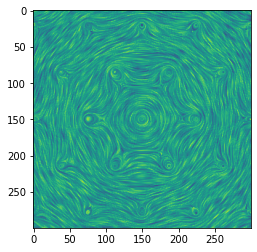

In [23]:
size = 300

np.random.seed(123)
texture = np.random.rand(size, size).astype(np.float64)
plt.imshow(texture, cmap="gray")
xs = np.linspace(-1,1,size).astype(np.float64)[None,:]
ys = np.linspace(-1,1,size).astype(np.float64)[:,None]

vx = np.zeros((size,size),dtype=np.float64)
vy = np.zeros((size,size),dtype=np.float64)
for (x,y) in vortices:
    rsq = (xs-x)**2+(ys-y)**2
    vx +=  (ys-y)/rsq
    vy += -(xs-x)/rsq
L = 10 # Radius of the kernel
kernel = np.sin(np.arange(2*L+1)*np.pi/(2*L+1)).astype(np.float64)
image = lic(vx, vy, texture, kernel)
plt.imshow(image, cmap='viridis')